In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import random
random.seed(0)
import torch
torch.manual_seed(0)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_google.csv')

In [2]:

data['Date'] = pd.to_datetime(data['Date'])
data = data[ data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
data = data[ data['Date'] >= pd.to_datetime('2013-01-01 00:00:00-04:00')]
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()
data.tail(3)

,Date,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,...,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_2,tema_100,tema_8,Close+1
4522,2022-12-27 00:00:00-05:00,88.800003,88.940002,87.010002,87.389999,20097300,2.741286,29.078087,29.466384,-31.184655,...,89.715997,3.606918,0.268245,86.320000,89.550003,87.975002,87.497793,89.535465,87.380232,86.019997
4523,2022-12-28 00:00:00-05:00,86.980003,88.040001,85.940002,86.019997,19523200,2.613118,20.079967,35.616463,-100.000000,...,90.176974,6.008927,0.209793,85.940002,89.550003,86.990002,86.024919,89.110476,86.348558,88.449997
4524,2022-12-29 00:00:00-05:00,86.620003,88.849998,86.610001,88.449997,23333500,2.870439,56.167551,25.250272,61.792939,...,89.276126,4.558455,0.792374,85.940002,88.940002,87.730000,88.291993,88.847738,87.099527,88.230003


In [3]:
data = data.drop(columns=['tema_2', 'tema_8'])
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'NATR_3', 'RSI_3',
       'ADX_3', 'CCI_3_0.015', 'ROC_3', 'STOCHk_14_3_3', 'STOCHd_14_3_3',
       'WILLR_3', 'OBV', 'MACD_12_26_9', 'BBL_3_2.0', 'BBM_3_2.0', 'BBU_3_2.0',
       'BBB_3_2.0', 'BBP_3_2.0', 'min_price_3', 'max_price_3', 'mid_price',
       'tema_100', 'Close+1'],
      dtype='object')

In [4]:


train = data[data['Date'] < pd.to_datetime('2022-01-01 00:00:00-04:00')]

val = data[data['Date'] < pd.to_datetime('2023-01-01 00:00:00-04:00')]
val = data[data['Date'] >= pd.to_datetime('2022-01-01 00:00:00-04:00')]

train = train.drop(columns=['Date'])
val = val.drop(columns=['Date'])


X_train = train.copy().drop(columns=['Close+1'])
y_train = pd.DataFrame()
y_train['Close+1'] = train[['Close+1']]

X_val = val.copy().drop(columns=['Close+1'])
y_val = pd.DataFrame()
y_val['Close+1'] = val[['Close+1']]
X_train.shape,X_val.shape,y_train.shape,y_val.shape


((2267, 24), (250, 24), (2267, 1), (250, 1))

In [5]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_train.shape, X_val.shape


((2267, 24), (250, 24))

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_train_scaled.shape, X_val_scaled.shape


((2267, 24), (250, 24))

In [7]:
from torch.utils.data import DataLoader,Dataset
sequence_length= 5
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y,sequence_length=5):
        self.X =  torch.tensor(X).float()
        self.y = torch.tensor(y).float()
        self.sequence_length = sequence_length
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i): 
       
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        elif self.sequence_length==1:
            return self.X[i],self.y[i]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            #print(padding.shape, x.shape)
            x = torch.cat((padding, x), 0)
            # x = self.X[0:i, :]
            #print(x.shape,padding.shape)

        return x, self.y[i]
       
train_dataset = TimeSeriesDataset(X_train_scaled, y_train, sequence_length=sequence_length)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val, sequence_length=sequence_length)

In [8]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [10]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,batch_first=True)

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(24, 64, 2)
model.to(device)
model

LSTM(
  (lstm): LSTM(24, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
losses = []
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    train_loss = 0
    num_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    
    print(f"train Error: Avg loss: {train_loss/num_batches:>8f}")
    losses.append((train_loss/num_batches))

In [12]:
val = []
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    
    val.append(test_loss)
    
    scheduler.step()
    #curr_lr = optimizer.param_groups[0]['lr']

    print(f"Test Error: Avg loss: {test_loss:>8f}  \n")

In [13]:
from torch.optim.lr_scheduler import StepLR

learning_rate = 0.01
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=200, gamma=0.1)

epochs = 2000
for t in range(epochs):
    if epochs %100==0:
        
        print(f"Epoch {t+1}\n-------------------------------")
    
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(val_loader, model, loss_fn)
print("Done!")




Epoch 1
-------------------------------


train Error: Avg loss: 2414.382654
Test Error: Avg loss: 7824.194092  

Epoch 2
-------------------------------
train Error: Avg loss: 1309.243858
Test Error: Avg loss: 5605.605164  

Epoch 3
-------------------------------
train Error: Avg loss: 1080.319698
Test Error: Avg loss: 4581.304688  

Epoch 4
-------------------------------
train Error: Avg loss: 1066.394334
Test Error: Avg loss: 4060.784210  

Epoch 5
-------------------------------
train Error: Avg loss: 926.317824
Test Error: Avg loss: 3413.672577  

Epoch 6
-------------------------------
train Error: Avg loss: 966.455241
Test Error: Avg loss: 3198.131165  

Epoch 7
-------------------------------
train Error: Avg loss: 719.420313
Test Error: Avg loss: 2770.949478  

Epoch 8
-------------------------------
train Error: Avg loss: 613.062355
Test Error: Avg loss: 2525.444321  

Epoch 9
-------------------------------
train Error: Avg loss: 541.516258
Test Error: Avg loss: 2206.534012  

Epoch 10
----------------------------

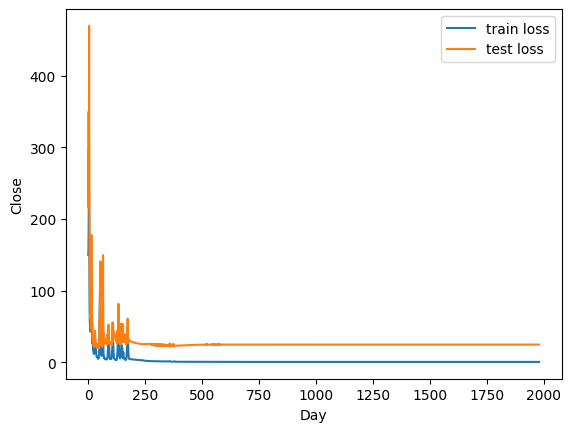

In [14]:
plt.plot(losses[20:], label='train loss')
plt.plot(val[20:], label='test loss')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

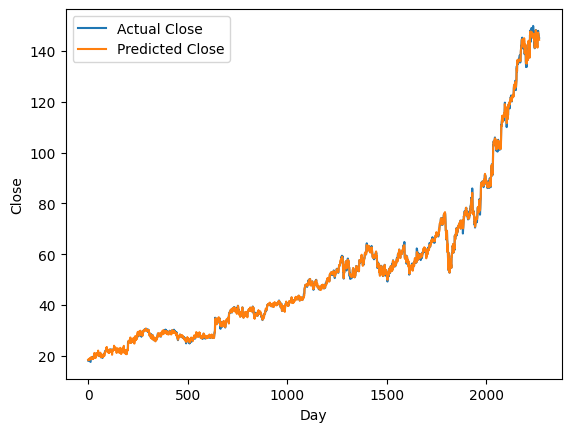

(tensor([89.1378]), array([88.73999786]))

In [15]:


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
count =0
output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in train_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        #print(X.shape,y.shape )
        #print(X.shape)
#print(count)
plt.plot(y_train, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
output[2000],y_train[2000]

torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([58, 5, 24]) torch.Size([58, 1])


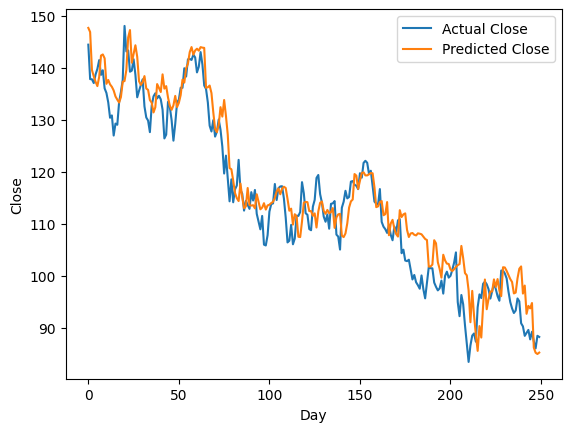

In [16]:

output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in val_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        print(X.shape,y.shape )
plt.plot(y_val, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [17]:
for batch, (X, y) in enumerate(train_dataset):
    print( (X.shape, y.shape))
    print( batch,(X, y))
    break

(torch.Size([5, 24]), torch.Size([1]))
0 (tensor([[-1.1625, -1.1614, -1.1592, -1.1590,  2.0691,  0.1677,  0.9764,  0.4521,
          1.1207,  0.7854, -0.1452, -0.3871,  1.0860, -2.1526, -0.2294, -1.1763,
         -1.1701, -1.1634,  0.8371,  1.1466, -1.1716, -1.1664, -1.1603, -1.1626],
        [-1.1625, -1.1614, -1.1592, -1.1590,  2.0691,  0.1677,  0.9764,  0.4521,
          1.1207,  0.7854, -0.1452, -0.3871,  1.0860, -2.1526, -0.2294, -1.1763,
         -1.1701, -1.1634,  0.8371,  1.1466, -1.1716, -1.1664, -1.1603, -1.1626],
        [-1.1625, -1.1614, -1.1592, -1.1590,  2.0691,  0.1677,  0.9764,  0.4521,
          1.1207,  0.7854, -0.1452, -0.3871,  1.0860, -2.1526, -0.2294, -1.1763,
         -1.1701, -1.1634,  0.8371,  1.1466, -1.1716, -1.1664, -1.1603, -1.1626],
        [-1.1625, -1.1614, -1.1592, -1.1590,  2.0691,  0.1677,  0.9764,  0.4521,
          1.1207,  0.7854, -0.1452, -0.3871,  1.0860, -2.1526, -0.2294, -1.1763,
         -1.1701, -1.1634,  0.8371,  1.1466, -1.1716, -1.1664, -

In [18]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(output,y_val))

4.9369167183640705

In [19]:
data = pd.read_csv('/Users/hieudao/Desktop/ai/do_an/clean_data/clean_google.csv')
data['Date'] = pd.to_datetime(data['Date'])
data['Close+1'] = data['Close'].shift(-1)
data = data.dropna()

test = data[data['Date'] >= pd.to_datetime('2023-01-01 00:00:00-04:00')]
test = test.drop(columns=['Date','tema_2','tema_8'])
test

,Open,High,Low,Close,Volume,NATR_3,RSI_3,ADX_3,CCI_3_0.015,ROC_3,...,BBL_3_2.0,BBM_3_2.0,BBU_3_2.0,BBB_3_2.0,BBP_3_2.0,min_price_3,max_price_3,mid_price,tema_100,Close+1
4526,89.589996,91.050003,88.519997,89.120003,28131200,2.821729,65.143396,34.889842,100.000000,3.603820,...,87.842988,88.600001,89.357014,1.708832,0.843456,86.570000,91.050003,89.785000,88.391649,88.080002
4527,90.349998,90.650002,87.269997,88.080002,34854800,3.346236,44.771562,27.755812,2.473400,-0.418310,...,87.558652,88.476669,89.394687,2.075163,0.283954,86.570000,91.050003,88.959999,88.147904,86.199997
4528,87.470001,87.570000,85.900002,86.199997,27194400,2.974110,24.227537,27.020606,-100.000000,-2.300812,...,85.383166,87.800001,90.216835,5.505319,0.168988,85.900002,91.050003,86.735001,87.808360,87.339996
4529,86.790001,87.690002,84.860001,87.339996,41381500,3.087752,46.540059,33.515097,-47.347253,-1.997314,...,85.660110,87.206665,88.753220,3.546874,0.543106,84.860001,90.650002,86.275002,87.552674,88.019997
4530,88.360001,90.050003,87.860001,88.019997,29003900,3.071375,57.688039,30.735766,100.000000,-0.068126,...,85.684902,87.186663,88.688425,3.444934,0.777452,84.860001,90.050003,88.955002,87.350789,88.419998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4648,119.239998,120.059998,118.300003,119.099998,24090900,2.208150,37.185949,55.252253,50.763377,0.642219,...,117.685763,119.203334,120.720904,2.546187,0.465954,116.099998,120.389999,119.180000,126.088071,119.699997
4649,120.169998,121.080002,119.690002,119.699997,29519700,1.925610,47.880285,38.544280,100.000000,1.157775,...,118.776368,119.659999,120.543629,1.476902,0.522633,116.849998,121.080002,120.385002,126.127617,119.900002
4650,119.239998,120.190002,118.820000,119.900002,14467900,1.532510,51.969111,34.240526,-2.406849,-0.232983,...,118.886795,119.566666,120.246537,1.137225,0.745146,118.300003,121.080002,119.505001,126.171657,121.750000
4651,119.239998,122.610001,119.230003,121.750000,27584800,2.142701,77.001957,37.303969,100.000000,2.225022,...,118.604283,120.449999,122.295716,3.064702,0.852167,118.820000,122.610001,120.920002,126.316152,120.110001


/usr/local/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


torch.Size([64, 5, 24]) torch.Size([64, 1])
torch.Size([63, 5, 24]) torch.Size([63, 1])


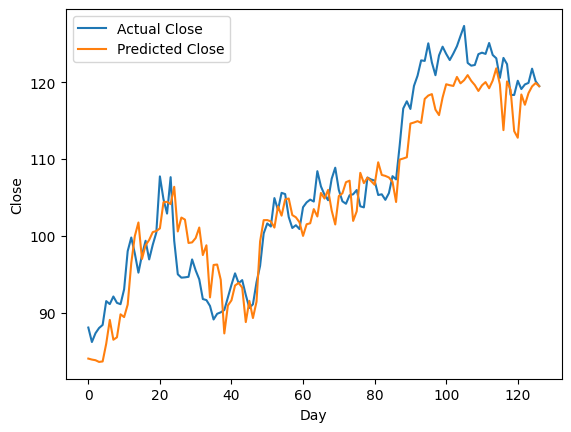

4.028204163517861

In [20]:



X_test = test.copy().drop(columns=['Close+1'])
y_test = pd.DataFrame()
y_test['Close+1'] = test[['Close+1']]

#X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

X_test_scaled = scaler.transform(X_test)

test_dataset = TimeSeriesDataset(X_test_scaled,y_test,sequence_length=sequence_length)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


output = torch.tensor([])
model.eval()
with torch.no_grad():
    for X, y in test_loader:
        y_star = model(X)
        output = torch.cat((output, y_star), 0)
        
        print(X.shape,y.shape )
#print(count)
plt.plot(y_test, label='Actual Close')
plt.plot(output, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()
np.sqrt(mean_squared_error(output,y_test))


In [21]:
y_test.shape, X_test_scaled.shape, output.shape

((127, 1), (127, 24), torch.Size([127, 1]))

In [22]:
(np.abs(output-y_test)/y_test).mean()*100


tensor(3.1487, dtype=torch.float64)